With this notebook we want to show you, how one can use the implemented Tensor classes.

# ExtendedTT and ExtendedFEMTT
The extended TT class is based on the tensor train formalism and uses the Hackbush interpretation, which integrates an additional basis for every node.

We focused on two main concepts here, which can be adapted and extended in the future.

First we define an ExtendedTT with one of the a priori known BasisType. 
Atm this can be

    - Legendre Polynomials (optional normalised)
    - Hermite Polynomials (optional normalised)
    - transformed Hermite Polynomials (optional normalised)
    - point-wise basis
    
The first types correspond to the usual UQ, global, polynomial chaos basis. The last one is the usual algebraic tensor structure. 

Out of convinience, we developed an inheriting class that forces the first component to be a finite element representation, having a fenics FunctionSpace object. 
The user is free to choose the function space, as long as a function can be identified by its .vector() component.

In [1]:
from alea.math_utils.tensor.extended_tt import ExtendedTT, BasisType
from alea.math_utils.tensor.extended_fem_tt import ExtendedFEMTT

# Creation

Let us start by creating a random algebraic tensor with $M$ modes having local dimensions $d=(d_1, \ldots, d_M)$ and ranks $r=(1, r_1, \ldots, r_M, 1)$.

Here, we use the Xerus library to create the tensor. (alternatively the Oseledets TT-Toolbox can do the same)

In [2]:
M = 5
d = [7, 9, 3, 5, 2]
r = [1, 4, 5, 4, 2, 1]

assert len(d) == M

import xerus as xe

tensor = xe.TTTensor.random(d, r[1:-1])

print("Xerus TT object: {}".format(tensor))
print("  d={}".format(tensor.dimensions))
print("  r={}".format(tensor.ranks()))
print("  M={}".format(tensor.degree()))

print("\n")
import tt as osel_tt

tensor_osel = osel_tt.rand(d, M, r)

print("Oseledets TT object: {}".format(tensor_osel))
print("  d={}".format(tensor_osel.n))
print("  r={}".format(tensor_osel.r))
print("  M={}".format(tensor_osel.d))

Xerus TT object: <xerus.TTTensor object at 0x2abceea5f5c8>
  d=[7, 9, 3, 5, 2]
  r=[4, 5, 4, 2]
  M=5


Oseledets TT object: This is a 5-dimensional tensor 
r(0)=1, n(0)=7 
r(1)=4, n(1)=9 
r(2)=5, n(2)=3 
r(3)=4, n(3)=5 
r(4)=2, n(4)=2 
r(5)=1 

  d=[7 9 3 5 2]
  r=[1 4 5 4 2 1]
  M=5


## Casting from and to other libraries
The ExtendedTT interface can be created from both, Oseledets TT-Toolbox tensors and Xerus TTTensor objects.

The same can be done in reverse.

In [3]:
ex_tensor = ExtendedTT.from_xerus_tt(tensor)
ex_tensor_osel = ExtendedTT.from_osel_tt(tensor_osel)

print(ex_tensor)
print(ex_tensor_osel)

ex_tensor_back = ex_tensor.to_xerus_tt()
ex_tensor_osel_back = ex_tensor_osel.to_osel_tt()

assert xe.frob_norm(tensor - ex_tensor_back) < 1e-10
assert osel_tt.vector.norm(tensor_osel - ex_tensor_osel_back) < 1e-10

Extended Tensor Train: 
 dimension: [7, 9, 3, 5, 2] 
 ranks: [1, 4, 5, 4, 2, 1] 
 basis: [<BasisType.points: 1>, <BasisType.points: 1>, <BasisType.points: 1>, <BasisType.points: 1>, <BasisType.points: 1>]
Extended Tensor Train: 
 dimension: [7, 9, 3, 5, 2] 
 ranks: [1, 4, 5, 4, 2, 1] 
 basis: [<BasisType.points: 1>, <BasisType.points: 1>, <BasisType.points: 1>, <BasisType.points: 1>, <BasisType.points: 1>]


# Simple operations

## Rounding
Those algebraically defined tensor trains are given in point-wise basis representation.
Now, you can operate on those objects and perform operations like rounding, left canonicalisation, saved and loaded.

In [4]:
ex_tensor_round = ex_tensor.copy()
# The rounding here uses the oseledets toolbox.
ex_tensor_round.round(tol=1e-3, max_r=4)
err = xe.frob_norm(ex_tensor.to_xerus_tt() - ex_tensor_round.to_xerus_tt())
print("Frobenius norm difference to rounded tensor: {}\n with ranks\n  old={}\n  new={}".format(err, ex_tensor.r, 
                                                                                                 ex_tensor_round.r))
# You can also use xerus to round or just use your own rounding algorithm on the components.
ex_tensor_round = ex_tensor.xe_round(tol=1e-3, max_r=2)
err = xe.frob_norm(ex_tensor.to_xerus_tt() - ex_tensor_round.to_xerus_tt())
print("Frobenius norm difference to rounded tensor: {}\n with ranks\n  old={}\n  new={}".format(err, ex_tensor.r, 
                                                                                                 ex_tensor_round.r))
# The difference is in the return value. This should be more consistend. My bad... 

Frobenius norm difference to rounded tensor: 76.9249025411
 with ranks
  old=[1, 4, 5, 4, 2, 1]
  new=[1, 4, 4, 4, 2, 1]
Frobenius norm difference to rounded tensor: 1.47254236453e-12
 with ranks
  old=[1, 4, 5, 4, 2, 1]
  new=[1, 4, 5, 4, 2, 1]


## Canonicalising 

In [5]:
ex_tensor_canonical = ex_tensor.canonicalize_left()
err = xe.frob_norm(ex_tensor.to_xerus_tt() - ex_tensor_canonical.to_xerus_tt())
print("Frobenius norm difference to canonicalised tensor: {}\n with ranks\n  old={}\n  new={}".format(err, ex_tensor.r, 
                                                                                                      ex_tensor_canonical.r))

Frobenius norm difference to canonicalised tensor: 1.97285246794e-13
 with ranks
  old=[1, 4, 5, 4, 2, 1]
  new=[1, 4, 5, 4, 2, 1]


## Save and Load

In [6]:
path = "local_saved_tensor.dat"
print(" tensor saved succesfully: {}".format(ex_tensor.save(path)))
ex_tensor_loaded = ExtendedTT.load(path)
err = xe.frob_norm(ex_tensor.to_xerus_tt() - ex_tensor_loaded.to_xerus_tt())
print("Frobenius norm difference to loaded tensor: {}\n with ranks\n  old={}\n  new={}".format(err, ex_tensor.r, 
                                                                                                 ex_tensor_loaded.r))

 tensor saved succesfully: True
<HDF5 file "local_saved_tensor.dat" (mode r)>
Frobenius norm difference to loaded tensor: 3.71493328797e-13
 with ranks
  old=[1, 4, 5, 4, 2, 1]
  new=[1, 4, 5, 4, 2, 1]


# Polynomial Basis Tensor Train

Let us now have a look at a specific extended Tensor Train, which includes a basis formulation. 
To do so, let's take another randomly created TT Tensor and assume, the components are the coefficients of a Legendre basis

$$
  A(x=(x_1, \ldots, x_M)) = \sum_{k_1=1}^{r_1}\dots\sum_{k_{M-1}=1}^{r_{M-1}} \prod_{m=1}^M \left(\sum_{\mu_m=0}^{d_m-1} A_m[k_{m-1}, \mu_m, k_m] P_{\mu_m}(x_m)\right),
$$
where $r_0 = r_M = 1$, $P_{\ell}$ denotes the Legendre polynomial of degree $\ell$ and $A_m\in \mathbb{R}^{r_{m-1}\times d_m\times r_m}$ are the components (component tensors, cores, ...)

In [7]:
A_m = xe.TTTensor.random(d, r[1:-1])   # create a random xerus tensor
A_m = ExtendedTT.from_xerus_tt(A_m)    # cast it to an extended TT
A_m = A_m.components                   # just to obtain the components... 

basis_list = [BasisType.Legendre] * M  # define the basis List as unnormalised Legendre polynomials
A = ExtendedTT(A_m, basis_list)        # create ExtendedTT with given Basis Type in every component
print(A)

Extended Tensor Train: 
 dimension: [7, 9, 3, 5, 2] 
 ranks: [1, 4, 5, 4, 2, 1] 
 basis: [<BasisType.Legendre: 2>, <BasisType.Legendre: 2>, <BasisType.Legendre: 2>, <BasisType.Legendre: 2>, <BasisType.Legendre: 2>]


In [ ]:
We can have a look at the involved one dimensional basis by 

## Algebraic operations
This ExtendedTT object can now be handled as a function. We can for instance add it with another tensor or multiply it with a constant or another tensor.

In [8]:
B = A.copy()                                # Let B be a copy of A
C = A + B                                   # C is the sum of A and B
import numpy as np                          # we use numpy here to create random numbers
for lia in range(10):
    y = np.random.rand(M)                   # create a random number
    assert C(y) - (A(y) + B(y)) < 1e-10     # assume the summation was successful

D = 0.2 * A                                 # multiply A with a constant number
for lia in range(10):
    y = np.random.rand(M)
    assert D(y) - (0.2*A(y)) < 1e-10        # assume the multiplication is correct
    
E = A.multiply_with_extendedTT(B)           # multiply A with B point-wise
for lia in range(10):
    y = np.random.rand(M)
    assert E(y) - (A(y) * B(y)) < 1e-10     # assume the product is correct

# Normalisation

Often it is desired to have the representation of a function in a normalised (orthonormal) Basis. 
The known basis types in the ExtendedTT class can be normalised by simply calling the 'normalise' function.

This change is done in-place and creates the same algebraic object, having a normalised basis representation.


In [13]:
B = A.copy()
B.normalise()
for lia in range(10):
    y = np.random.rand(M)
    assert B(y) - A(y) < 1e-10
print(B.basis)

norm 0 : 1.0
norm 1 : 0.57735026919
norm 2 : 0.4472135955
norm 3 : 0.377964473009
norm 4 : 0.333333333333
norm 5 : 0.301511344578
norm 6 : 0.277350098113
norm 0 : 1.0
norm 1 : 0.57735026919
norm 2 : 0.4472135955
norm 3 : 0.377964473009
norm 4 : 0.333333333333
norm 5 : 0.301511344578
norm 6 : 0.277350098113
norm 7 : 0.258198889747
norm 8 : 0.242535625036
norm 0 : 1.0
norm 1 : 0.57735026919
norm 2 : 0.4472135955
norm 0 : 1.0
norm 1 : 0.57735026919
norm 2 : 0.4472135955
norm 3 : 0.377964473009
norm 4 : 0.333333333333
norm 0 : 1.0
norm 1 : 0.57735026919
[<BasisType.NormalisedLegendre: 3>, <BasisType.NormalisedLegendre: 3>, <BasisType.NormalisedLegendre: 3>, <BasisType.NormalisedLegendre: 3>, <BasisType.NormalisedLegendre: 3>]


We can check the fact that the basis system is normalised by creating a tensor, that reflects the evaluation of the basis.
More precise, we want to have a set of order 1 tensors $(B_k)_k$ such that

$$
B_k(x) = P_k(x), \qquad k=1,2, \ldots
$$

Then, we compute the norm of the tensor products (by a simple quadrature scheme) before, and after normalisation.
For the Legendre polynomials, we know that 

$$ 
  \int_{-1}^1 P_k(x)P_\ell \mathrm{d}(x) = \frac{2}{2k+1} \delta_{k, \ell}.
$$
in case they are un-normalised and 
$$ 
  \int_{-1}^1 P_k(x)P_\ell \mathrm{d}(x) = 2 \delta_{k, \ell}.
$$
if we have normalised polynomials.

The factor 2 is due to the fact that the polynomials are orthonormal with respect to the uniform probability measure on $(-1, 1)$, which has the density 
$$\mathrm{d}\mathcal{U}(-1, 1,) (x) = \frac{1}{2}$$.

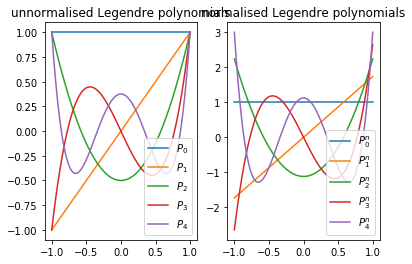

[[ 2.            0.           -0.            0.            0.          ]
 [ 0.            0.6666666667  0.           -0.            0.          ]
 [-0.           -0.            0.4           0.            0.          ]
 [ 0.           -0.            0.            0.2857142857  0.          ]
 [ 0.            0.            0.            0.            0.2222222222]]
[[ 2.            0.            0.            0.            0.          ]
 [ 0.            0.6666666667  0.            0.            0.          ]
 [ 0.            0.            0.4           0.            0.          ]
 [ 0.            0.            0.            0.2857142857  0.          ]
 [ 0.            0.            0.            0.            0.2222222222]]


In [18]:
def poly_ten(k):
    assert k >= 0
    comp_list = [np.zeros((1, k+1, 1))]
    comp_list[0][0, k, 0] = 1
    return ExtendedTT(comp_list, [BasisType.Legendre])

ten_list = [poly_ten(k) for k in range(5)]


import matplotlib.pyplot as plt
%matplotlib inline

grid = np.linspace(-1, 1, endpoint=True, num=100)

plt.subplot(121)
for k in range(5):
    ten = ten_list[k]
    values = [ten([x]) for x in grid]
    plt.plot(grid, values, label="$P_{}$".format(k))
plt.legend()
plt.title("unnormalised Legendre polynomials")

plt.subplot(122)
for k in range(5):
    ten = ten_list[k]
    ten.basis[0] = BasisType.NormalisedLegendre
    values = [ten([x]) for x in grid]
    plt.plot(grid, values, label="$P^n_{}$".format(k))
plt.legend()
plt.title("normalised Legendre polynomials")
plt.show()


from numpy.polynomial.legendre import leggauss

nodes, weights = leggauss(10)

int_mat = np.zeros((len(ten_list), len(ten_list)))
int_mat_norm = np.zeros((len(ten_list), len(ten_list)))

for lia in range(len(ten_list)):
    for lib in range(len(ten_list)):
        ten1 = ten_list[lia]
        ten2 = ten_list[lib]
        ten1.basis[0] = BasisType.Legendre
        ten2.basis[0] = BasisType.Legendre
        int_mat[lia, lib] = np.sum([weight * ten1([node])*ten2([node]) for (node, weight) in zip(nodes, weights)])
        ten1.basis[0] = BasisType.NormalisedLegendre
        ten2.basis[0] = BasisType.NormalisedLegendre
        int_mat_norm[lia, lib] = np.sum([weight * ten1([node])*ten2([node]) for (node, weight) in zip(nodes, weights)])

int_mat_true = np.diag([2*(2*k+1)**(-1) for k in range(len(ten_list))])
int_mat_norm_true = 2*np.eye(len(ten_list), len(ten_list))

assert np.linalg.norm(int_mat - int_mat_true) < 1e-10
assert np.linalg.norm(int_mat_norm - int_mat_norm_true) < 1e-10



# Integrated quantities

Especially in UQ applications, it is often a task to compute the expectation or the variance of a functional.
If represented as an Extended TT, those computations can be carried out very efficiently.
Assume, $\gamma$ is a probability measure on $(\Gamma, \mathcal{B}(\Gamma))$, sucht that the polynomials $(P_\mu)_{\mu}$ are orthonormal w.r.t. $\gamma$, i.e.
$$
  \int_\Gamma P_\mu(x) P_\nu(x) \mathrm{d}\gamma(x) = \delta_{\mu,\nu}.
$$

Moreover, let $A(x)$ be given as above.
Then, the expectation of $A$ w.r.t. to $\gamma$ is given by
$$
  \mathbb{E}\left[A\right] = \int A(x) \mathrm{d}\gamma(x) = \sum_{k_1=1}^{r_1}\dots\sum_{k_{M-1}=1}^{r_{M-1}} \prod_{m=1}^M A_m[k_{m-1}, 0, k_m]
$$

which is an $M$ fold matrix-vector multiplication.

In [ ]:

mean = A.mean()
print("Expectation (mean) of A: {}".format(mean))